In [1]:
from pyCascade import geomCreate as gC
from pyCascade import probeSetup
from solid import *
import numpy as np
from matplotlib import pyplot as plt
import pandas
from stl import mesh
from mpl_toolkits import mplot3d

# working_dir = pathlib.Path().absolute()
category =  "single_family"
run = 3

# ############ CLUSTER ################
# working_dir = '/scratch/users/nbachand/Cascade/city_block_cfd'

########### LOCAL ###################
working_dir = '/home/nbachand/Documents/Cascade/city_block'

In [2]:
wthick = 0.1
x = 10
y = 10
z = 10
wthick = .01
nx=3
ny=1
nz=2
roof_height = y
house_grid = [12,8]
house_spacing = [4*y,6*y]
interior_house = [6,4]
odd_offset = [2*z, 0]

house_dims = [nx*x, ny*y + roof_height, nz*z]
house_seperation = [house_spacing[0]-house_dims[0], 0, house_spacing[1]-house_dims[2]]

domain_size = [odd_offset[d] + house_grid[d]*house_spacing[d] for d in [0,1]]
domain_height = max(domain_size)
domain_size.insert(1, domain_height)

print(domain_size)


[500, 500, 480]


Vertical Profiles

In [3]:
Ly = domain_height
n_stack_floor = int(Ly+1)
n_stack_roof = int(Ly-(house_dims[1]))

probe_cols = {  #house_coordinate: probeSetup.y_coly_col inputs
    (3,2): (house_dims[0]/2, -house_seperation[2]/2, [0, Ly], n_stack_floor),
    (9,2): (-house_seperation[0]/2, house_dims[2]/2, [0, Ly], n_stack_floor),
    (3,6): (-house_seperation[0]/2, -house_seperation[2]/2, [0, Ly], n_stack_floor),
    (9,6): (house_dims[0]/2, house_dims[2]/2, [house_dims[1], Ly], n_stack_floor)
}

In [4]:
rooms, rooms_params = gC.makeRooms(x,y,z,wthick,nx,ny,nz)
exterior = gC.ProbedGeom(cube(house_dims))
roof = gC.makeRoof((0, x*nx), (y*ny, ny*y + roof_height), (0, z*nz))
doors = gC.makeDoors(rooms_params, y*.25, y*.75, 10, 10)
windows = gC.makeWindows(rooms_params, y*.25, y*.25, 10, 10)

print(domain_size)

house_list = []
house_coordinates = {}
for i in range(house_grid[0]):
    for k in range(house_grid[1]):
        if [i,k] == interior_house:
            house = exterior+roof-rooms-doors-windows
        else:
            house = exterior+roof
        if (i, k) in probe_cols:
            house.probes += [{
                "name": f"col_{i}-{k}",
                "tile": probeSetup.y_col(*probe_cols[(i, k)])
            }]
        del_x = (house_spacing[0]-x*nx)/2 + odd_offset[0]*(k%2) + i*house_spacing[0]
        del_z = (house_spacing[1]-z*nz)/2 + odd_offset[1]*(i%2) + k*house_spacing[1]
        house.translate([del_x, 0, del_z])
        house_list.append(house)

        house_coordinates[i, k] = [del_x, 0, del_z]

houses = gC.sumProbedGeom(house_list)

domain = gC.ProbedGeom(cube(domain_size))

neighborhood = domain - houses

geom_path = f"{working_dir}/city_block_geom/OpenSCAD/test"
scad_render_to_file(neighborhood.geom, f"{geom_path}/neighborhood.scad")
print(len(neighborhood.probes))


[500, 500, 480]
21


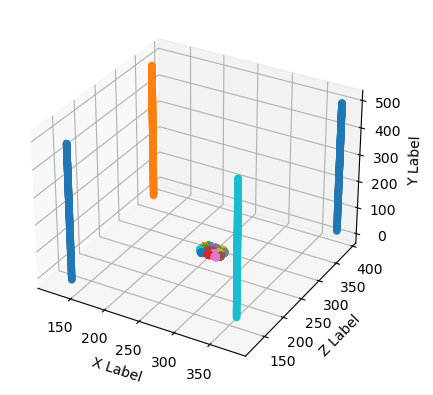

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].

for p in neighborhood.probes:
    ax.scatter(p["tile"][:,0], p["tile"][:,2], p["tile"][:,1], marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Z Label')
ax.set_zlabel('Y Label')

plt.show()

neighborhood.write_probes(f"{working_dir}/CHARLES/{category}/R{run}/probes/locations/")

In [6]:
for p in neighborhood.probes:
    name = p['name']
    print(f"POINTCLOUD_PROBE NAME=probes/probesOut/{name} INTERVAL=1 PRECISION=FLOAT FORMAT=FLOAT GEOM=FILE probes/locations/{name}.txt   VARS=comp(u,0) comp(u,1) comp(u,2)")

POINTCLOUD_PROBE NAME=probes/probesOut/col_3-2 INTERVAL=1 PRECISION=FLOAT FORMAT=FLOAT GEOM=FILE probes/locations/col_3-2.txt   VARS=comp(u,0) comp(u,1) comp(u,2))
POINTCLOUD_PROBE NAME=probes/probesOut/col_3-6 INTERVAL=1 PRECISION=FLOAT FORMAT=FLOAT GEOM=FILE probes/locations/col_3-6.txt   VARS=comp(u,0) comp(u,1) comp(u,2))
POINTCLOUD_PROBE NAME=probes/probesOut/zdoor_0-1 INTERVAL=1 PRECISION=FLOAT FORMAT=FLOAT GEOM=FILE probes/locations/zdoor_0-1.txt   VARS=comp(u,0) comp(u,1) comp(u,2))
POINTCLOUD_PROBE NAME=probes/probesOut/xdoor_1-0 INTERVAL=1 PRECISION=FLOAT FORMAT=FLOAT GEOM=FILE probes/locations/xdoor_1-0.txt   VARS=comp(u,0) comp(u,1) comp(u,2))
POINTCLOUD_PROBE NAME=probes/probesOut/xdoor_1-1 INTERVAL=1 PRECISION=FLOAT FORMAT=FLOAT GEOM=FILE probes/locations/xdoor_1-1.txt   VARS=comp(u,0) comp(u,1) comp(u,2))
POINTCLOUD_PROBE NAME=probes/probesOut/zdoor_1-1 INTERVAL=1 PRECISION=FLOAT FORMAT=FLOAT GEOM=FILE probes/locations/zdoor_1-1.txt   VARS=comp(u,0) comp(u,1) comp(u,2))


In [7]:
scad_render_to_file(houses.geom, f"{geom_path}/houses.scad")

'/home/nbachand/Documents/Cascade/city_block/city_block_geom/OpenSCAD/test/houses.scad'

NameError: name 'geom_stl' is not defined

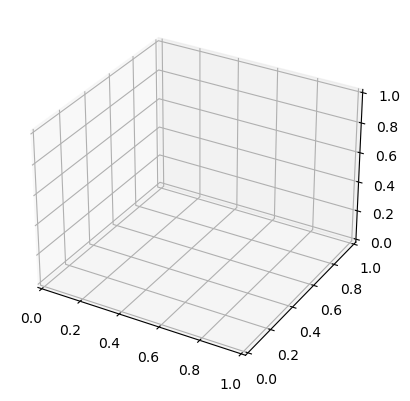

In [8]:
figure = plt.figure()
ax = figure.add_subplot(projection='3d')

plot_vectors = geom_stl.vectors
# plot_vectors[...,1] = geom_stl.vectors[...,2]
# plot_vectors[...,2] = geom_stl.vectors[...,1]

# Load the STL files and add the vectors to the plot
geom_stl = mesh.Mesh.from_file(f"{geom_path}/houses.stl")
ax.add_collection3d(mplot3d.art3d.Poly3DCollection(plot_vectors))

# Auto scale to the mesh size
scale = geom_stl.points.flatten()
ax.auto_scale_xyz(scale, scale, scale)

for p in neighborhood.probes:
    ax.scatter(p["tile"][:,0], p["tile"][:,1], p["tile"][:,2], marker='o')

# Show the plot to the screen
ax.view_init(45, 45)
plt.show()

resolution_value = 1200
plt.savefig(f"{geom_path}/houses.png", format="png")

Window Probes

In [ ]:
scad_render_to_file(roof.geom, f"{geom_path}/roof.scad")

'/home/nbachand/Documents/Cascade/city_block/city_block_geom/OpenSCAD/test/roof.scad'